# PyEMIS example

This is a simple example of how the pyEMIS library could be used

## Import some stuff

We need the model package and just a few things to make data 

In [1]:
from datetime import datetime, timedelta 
import time
import numpy as np
from matplotlib import pyplot as plt

from lib.ConsumptionModels import *

%matplotlib inline

## Create a dataset

The first thing to do is create a dataset. In the future this should be handled with pandas. Pandas was new-ish when I wrote the pyEMIS library so I didn't take it on. Now I would use Pandas for most of the internals as well as for the main input/output data structures.

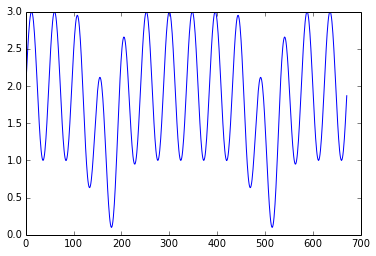

In [23]:
n = 336 * 53 # 53 weeks of half-hourly data

#a series of datetimes starting in March
start = datetime.now().replace(month=3) - timedelta(minutes=(n * 30))
dt = [start + timedelta(minutes=i * 30) for i in xrange(n)]

# some patterns to make it interesting
diurnal = np.tile(np.sin((2*np.pi/48) * np.arange(48) + 24), n/48)
seasonal = np.sin((2*np.pi/(336*52)) * np.arange(n))
occupancy = np.tile(
    np.sin((2 * np.pi / 48) * np.arange(336)) -
    np.abs(np.power(np.sin((2 * np.pi / (2 * 336)) * np.arange(336)), 18)) + 2, n / 336
)

#Simple temperature data
temperature = (diurnal * 5) + (seasonal * 15) * 0.5 + 10

#degree days at base 15.5
dd = np.array([max(0, 15.5 - t) for t in temperature])

# Consumption
consumption = dd * occupancy + (10 * occupancy)
consumption = consumption + np.random.randn(n) * np.mean(consumption) * 0.25

plt.plot(occupancy[:336*2])

In [24]:
timestamps = [time.mktime(t.timetuple()) for t in dt]
data = np.array(zip(consumption, temperature, timestamps), dtype=[('consumption', 'int32'), ('temperature', 'int32'), ('timestamp', 'float')])

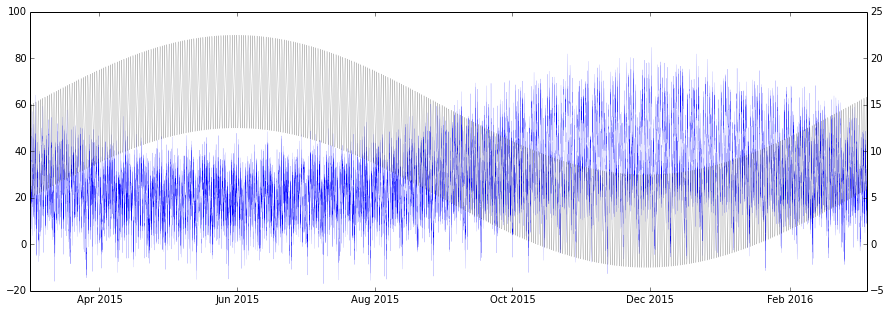

In [25]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax2 = ax1.twinx()
ax1.plot(dt, consumption, color='blue', lw=0.1)
ax2.plot(dt, temperature, color='black', lw=0.25, alpha=0.5)

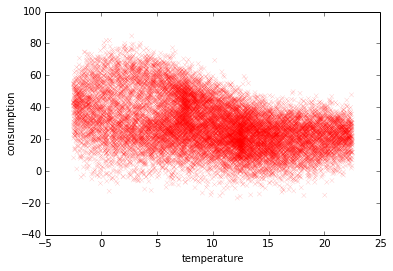

In [26]:
plt.scatter(temperature, consumption, marker='x', color='red', lw=0.1, alpha=0.9)
plt.xlabel('temperature')
plt.ylabel('consumption')

## Create a model factory

The model factory produces models from data. We are using a standard Weekly factory to divide consumption into 336 half-hourly slots and applying the selective AnyModel which will choose the best model to apply to each subset.

In [27]:
factory = WeeklyModelFactory(AnyModelFactory(), timedelta(minutes=30))

## Fit the model

Factories are callable so just pass in data to create a model instance. Here we pass in one year of data.

In [28]:
model = factory(data[:17520])

## Use the model to generate outputs

Here we do the standard thing of generating percentile ranges based on the baseline model residuals and generate a prediction for the latest week of data. 

In [33]:
perc = model.percentiles(data[:17520], [5, 25, 75, 95], expand=False)
pred = model.prediction(data[-336:])

Here we are adding the percentile ranges to the prediction in order to generate ranges of consumption.

In [34]:
levels = {key: pred + perc[key][-336:] for key in ['5', '25', '75', '95']}

# Plot the results

A simple plot shows our ranges as good, neutral and bad consumption bands. Compare the actual data to the 'expected' range. The data goes out of the colours areas rarely. Only 10% (~34) of the points are expected to be below 5th percentile or above 95th percentile.

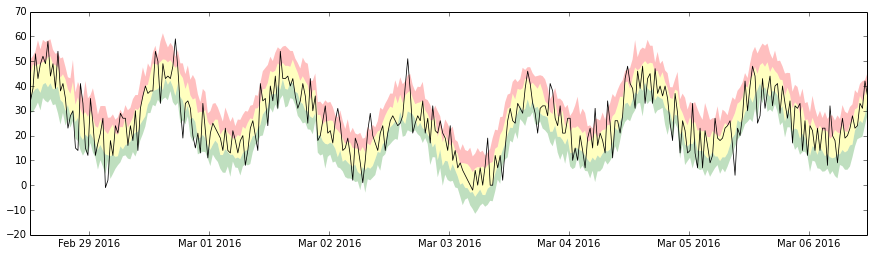

In [37]:
plt.figure(figsize=(15, 4))
plt.fill_between(dt[-336:], levels['5'], levels['25'], color='green', lw=0, alpha=0.25)
plt.fill_between(dt[-336:], levels['25'], levels['75'], color='yellow', lw=0, alpha=0.25)
plt.fill_between(dt[-336:], levels['75'], levels['95'], color='red', lw=0, alpha=0.25)
plt.plot(dt[-336:], data[-336:]['consumption'], color='black', lw=0.75)